# Exercise 04 : Histogram

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [2]:
con = sqlite3.connect("../data/checking-logs.sqlite")

In [3]:
query = """
SELECT timestamp
FROM checker
WHERE uid LIKE 'user_%'
"""
checker = pd.io.sql.read_sql(query, con, parse_dates=['timestamp'])
checker['day'] = checker['timestamp'].dt.day
checker['weekday'] = checker['timestamp'].dt.dayofweek
checker['hour'] = checker['timestamp'].dt.hour
checker['type'] = checker['weekday'].apply(
    lambda x: "working_day" if x < 5 else "weekend"
)
checker = checker.drop(columns = ['weekday'])
checker

,timestamp,day,hour,type
0,2020-04-17 05:19:02.744528,17,5,working_day
1,2020-04-17 05:22:35.249331,17,5,working_day
2,2020-04-17 05:22:45.549397,17,5,working_day
3,2020-04-17 05:34:14.691200,17,5,working_day
4,2020-04-17 05:34:24.422370,17,5,working_day
...,...,...,...,...
3202,2020-05-21 20:19:06.872761,21,20,working_day
3203,2020-05-21 20:22:41.785725,21,20,working_day
3204,2020-05-21 20:22:41.877806,21,20,working_day
3205,2020-05-21 20:37:00.129678,21,20,working_day


In [4]:
working = checker[checker['type'] == 'working_day'][['hour']].reset_index(drop=True)
working

,hour
0,5
1,5
2,5
3,5
4,5
...,...
2032,20
2033,20
2034,20
2035,20


In [5]:
weekend = checker[checker['type'] == 'weekend'][['hour']].reset_index(drop=True)
weekend

,hour
0,7
1,13
2,13
3,13
4,13
...,...
1165,22
1166,22
1167,22
1168,22


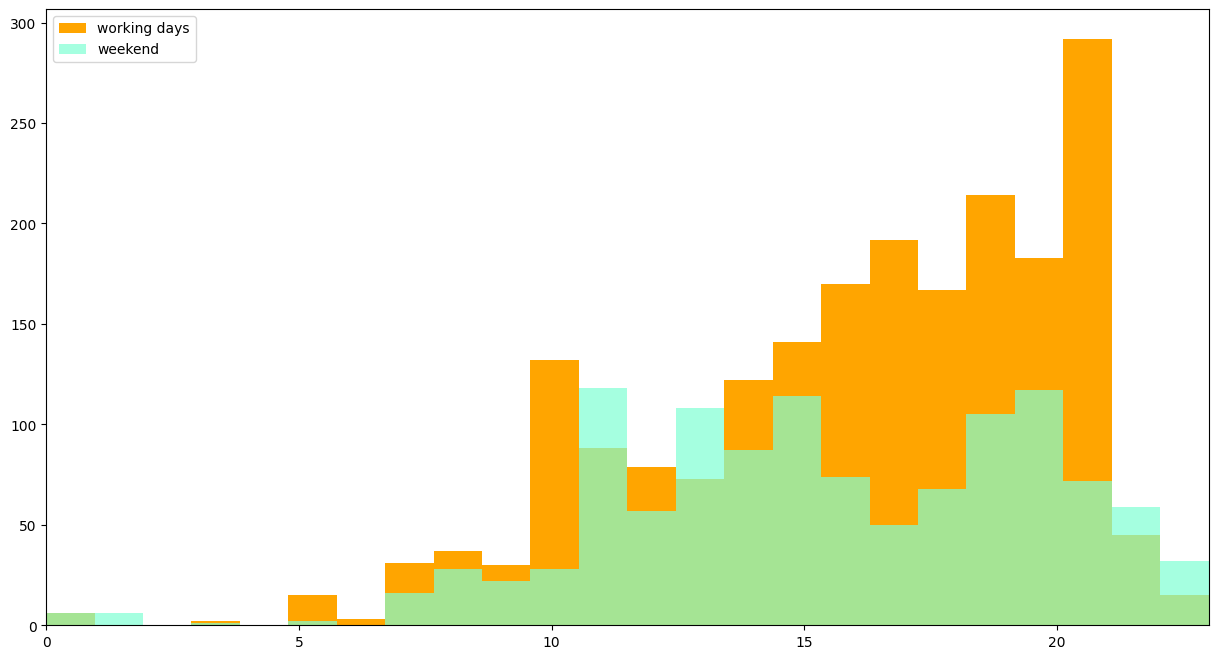

In [6]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.hist(working['hour'],
        bins=24,
        label='working days',
        color='orange')
ax.hist(weekend['hour'],
        bins=24,
        label='weekend',
        color='aquamarine',
        alpha=0.7)
ax.set_xlim(0, 23)
ax.legend(loc='upper left', fontsize='10')
plt.show()

## Are there hours when the total number of commits was higher on weekends than on working days?

In [7]:
checker = checker.drop(columns=['timestamp'])
checker = checker.groupby(['type', 'hour']).count()
pivot = pd.pivot_table(checker,
                 values='day',
                 index='hour',
                 columns='type')
df = pivot.index
for i in range(0, 24):
    if i not in df:
        pivot.loc[i] = [0, 0]
pivot.sort_index(inplace=True)
pivot = pivot.fillna(0)
pivot['delta'] = pivot['weekend'] - pivot['working_day']
pivot.loc[pivot['delta'].nlargest(4).index]


type,weekend,working_day,delta
hour,,,
13,108.0,73.0,35.0
11,118.0,88.0,30.0
23,32.0,15.0,17.0
22,59.0,45.0,14.0


## The answer is __13, 11, 23, 22__

In [8]:
con.close()